<!--

### Requirements:

You need to .....

1. simualtion track
2. hardware track
    - DB21M up and running
    - 2 AprilTags

### Intended outcomes:

Calibrate the Duckiebot kinematic model using the data from the wheel encoders.

### Steps:

1. Theory  
2. Approach
3. Implementation
4. Validation



1. Theory -> Review odometry class
2. Approach -> 
    - Use wheel encoders to estimate the pose of the DB using deadrecknonig approximation. 
    - Use estimate and ground truth to best fit

3. Implementation ->
    - Read the data from the wheel encoders 
        - Sim:
        - HW :
            
    - Obtain the gorund truth from AprilTags


4. Validation

1. Theoretical understanding of the Duckiebot kinematic model, in particular what the parameters _R_ and _L_ represent.
2. Approach:
    - Wheel encoders and deadrecknonig
    
    - Straight path 
    - Curved path (e.g., sinusoidal)

3. Validation of the resulting parameters.

-->

<p style="text-align: right">
  <img src="../images/dtlogo.png" alt="Logo" width="200">
</p>

# 🚙 💻 04- Wheel encoders tutorial

Encoders are sensors that convert analog angular position or motion of a shaft into a digital signal. In Duckietown we use [Hall Effect Encoders](https://en.wikipedia.org/wiki/Hall-effect_sensor), which are able to extract the incremental change in angular position of the wheels. 

This is very useful, since it can be used to accurately map the position of the Duckiebot while it moves in the Duckietown. Duckietown wheel encoders (from Duckiebot model `DB21M`) provide a phase signal too, so we catch in which direction (forward, backwards) each wheel is spinning. 

In this tutorial we will learn how to access the data coming from the wheel encoders of our Duckiebot (whether physical or simulated), and understand what each field means. We will use this data for later activities.

## 🚙 💻 Obtaining wheel encoder measurements. 

Let's look at what data the wheel encoders produce. 
 
<!--

The first step to evaluate to Duckiebot's odometry is to measure the data from the wheel encoders. Let's get some of these messages and understand what they mean.

-->

### 💻 Read data from wheel encoders (simulation)

To observe the wheel encoder data in simulation:

1. Open a terminal on your computer
    * navigate to the activity folder
    * `dts exercises build`
    * `dts exercises test --sim`
    * scroll up in the terminal and find localhost address VNC and paste in browser
    * Connect to VNC, open RQT image view (icon on the desktop), and select compressed image topic from the top left dropdown menu
    
<p style="text-align:center;">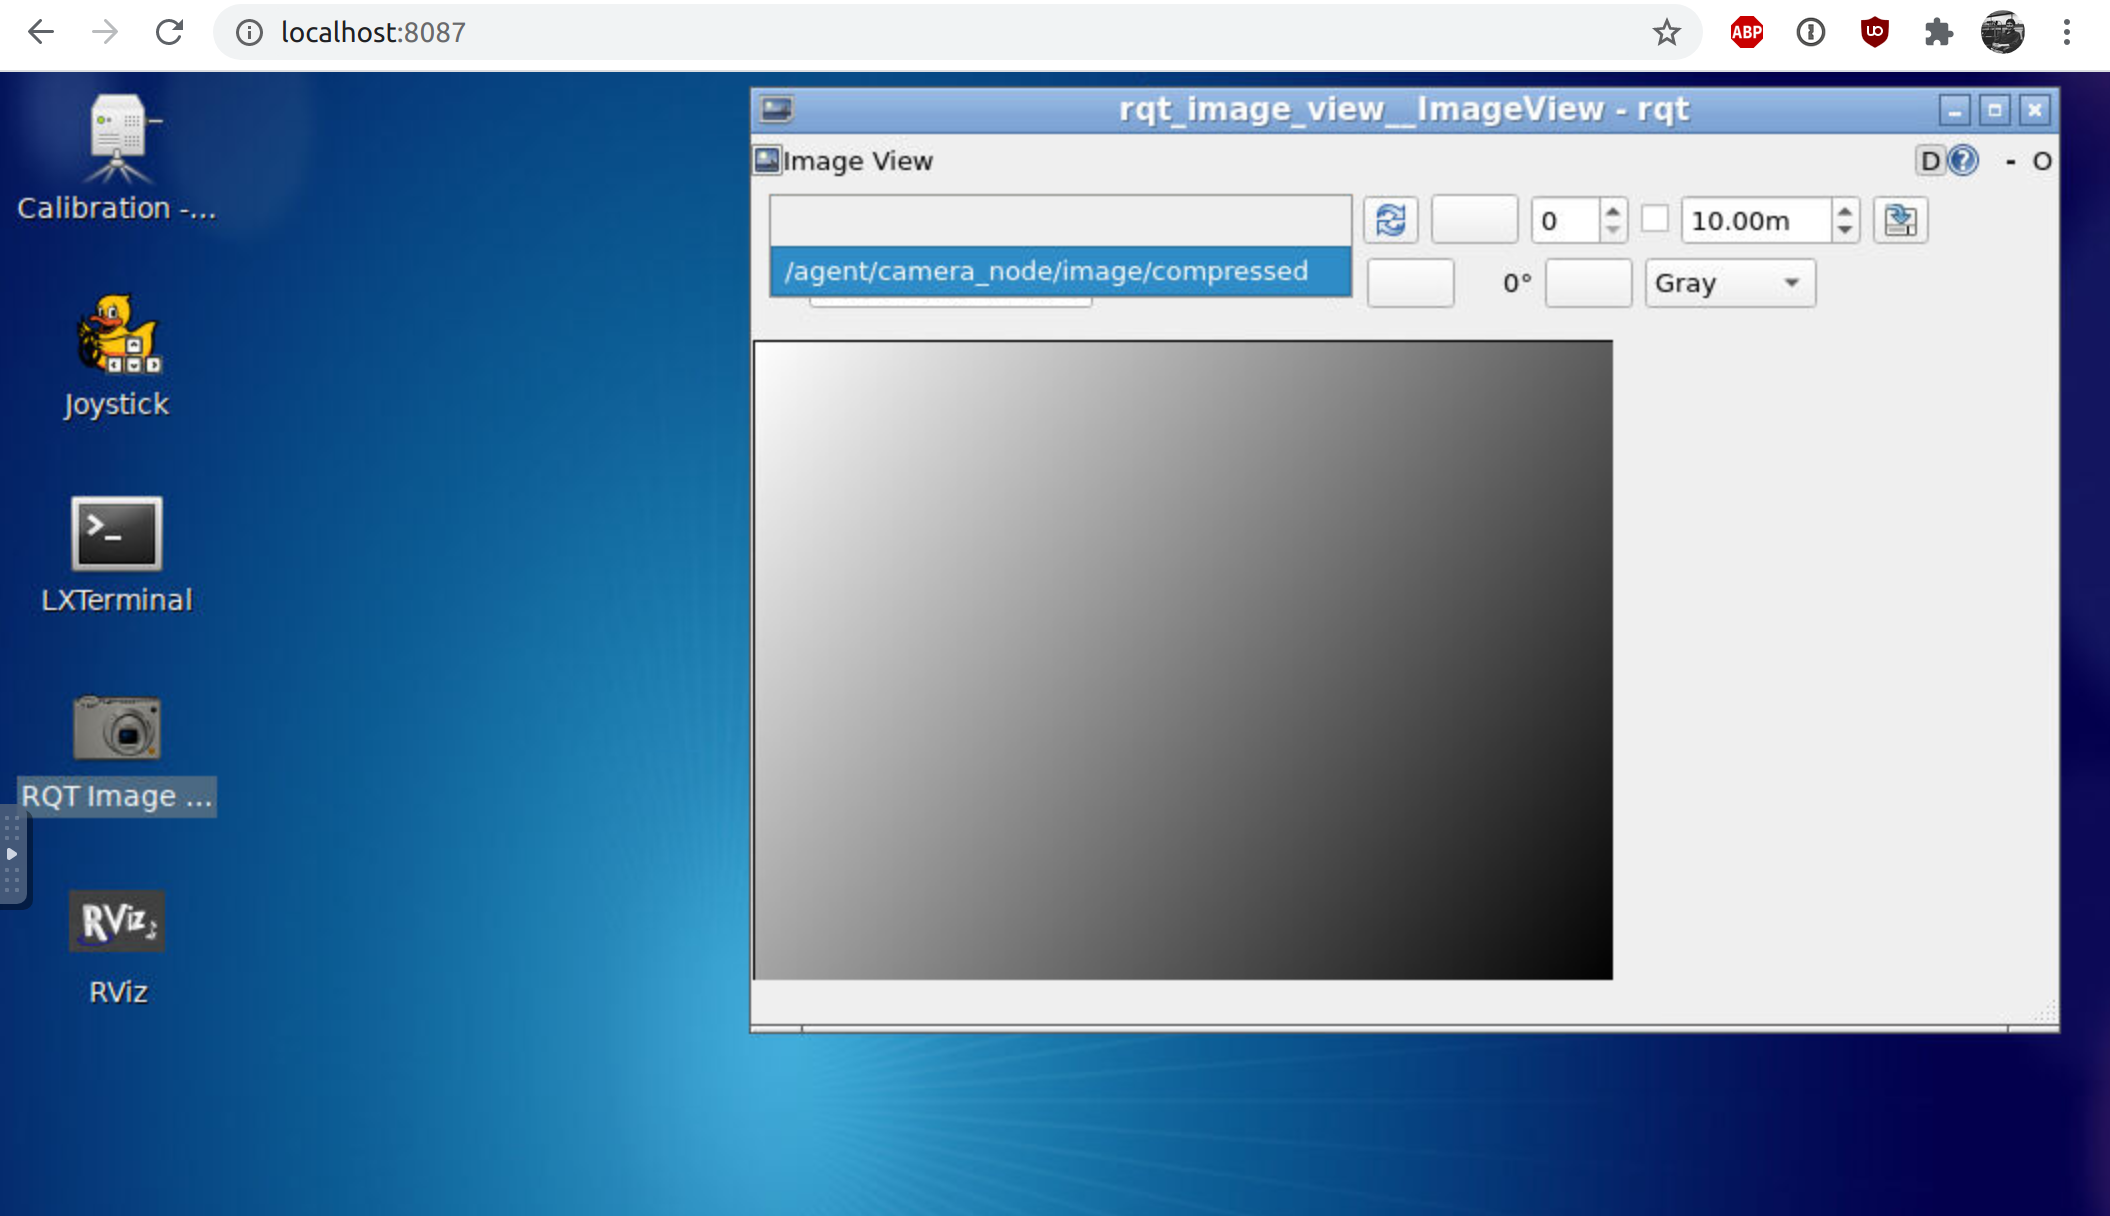</p>

You should see what your simulated Duckiebot sees.
        
<p style="text-align:center;">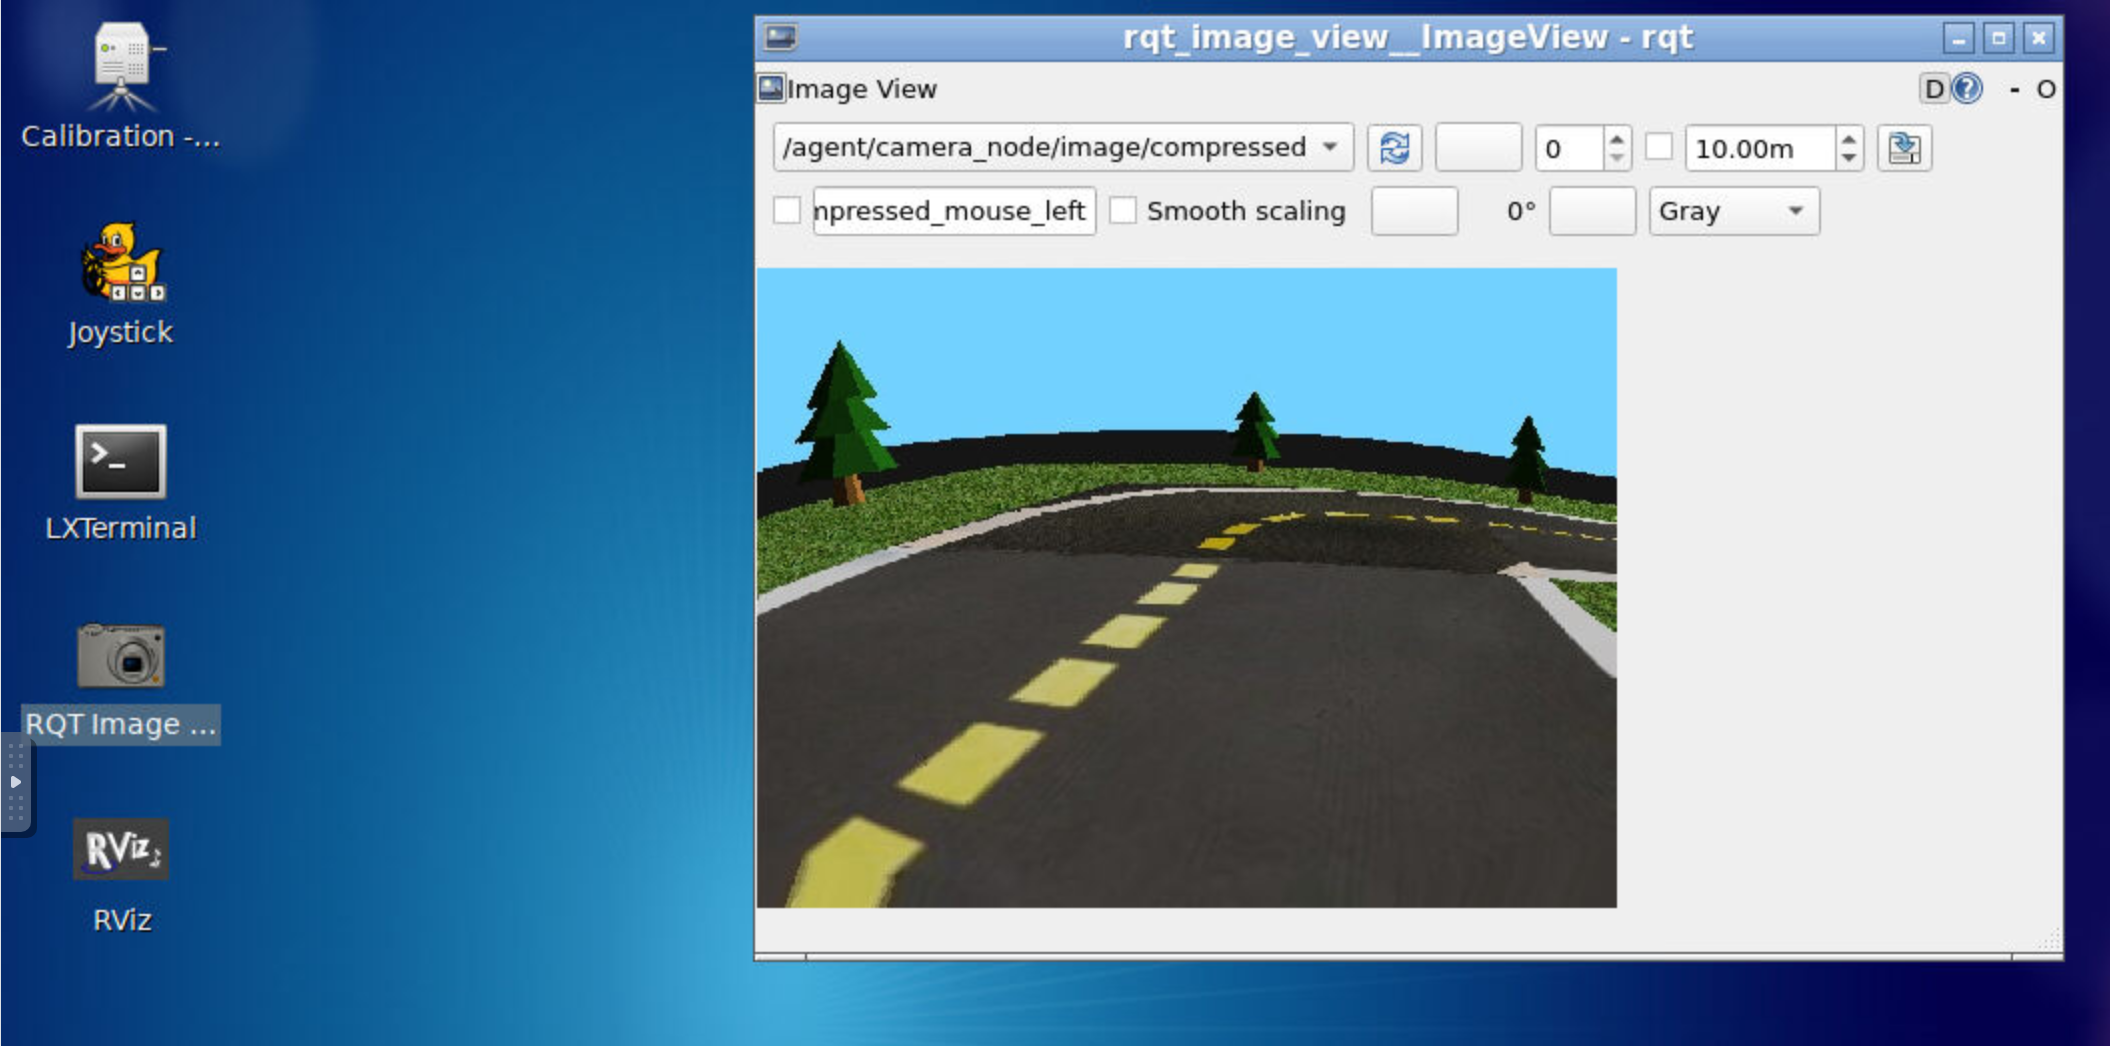</p>
        
2. Open LX terminal inside VNC, and type:

       rostopic list

to see the list of topics running on agent. 

<p style="text-align:center;">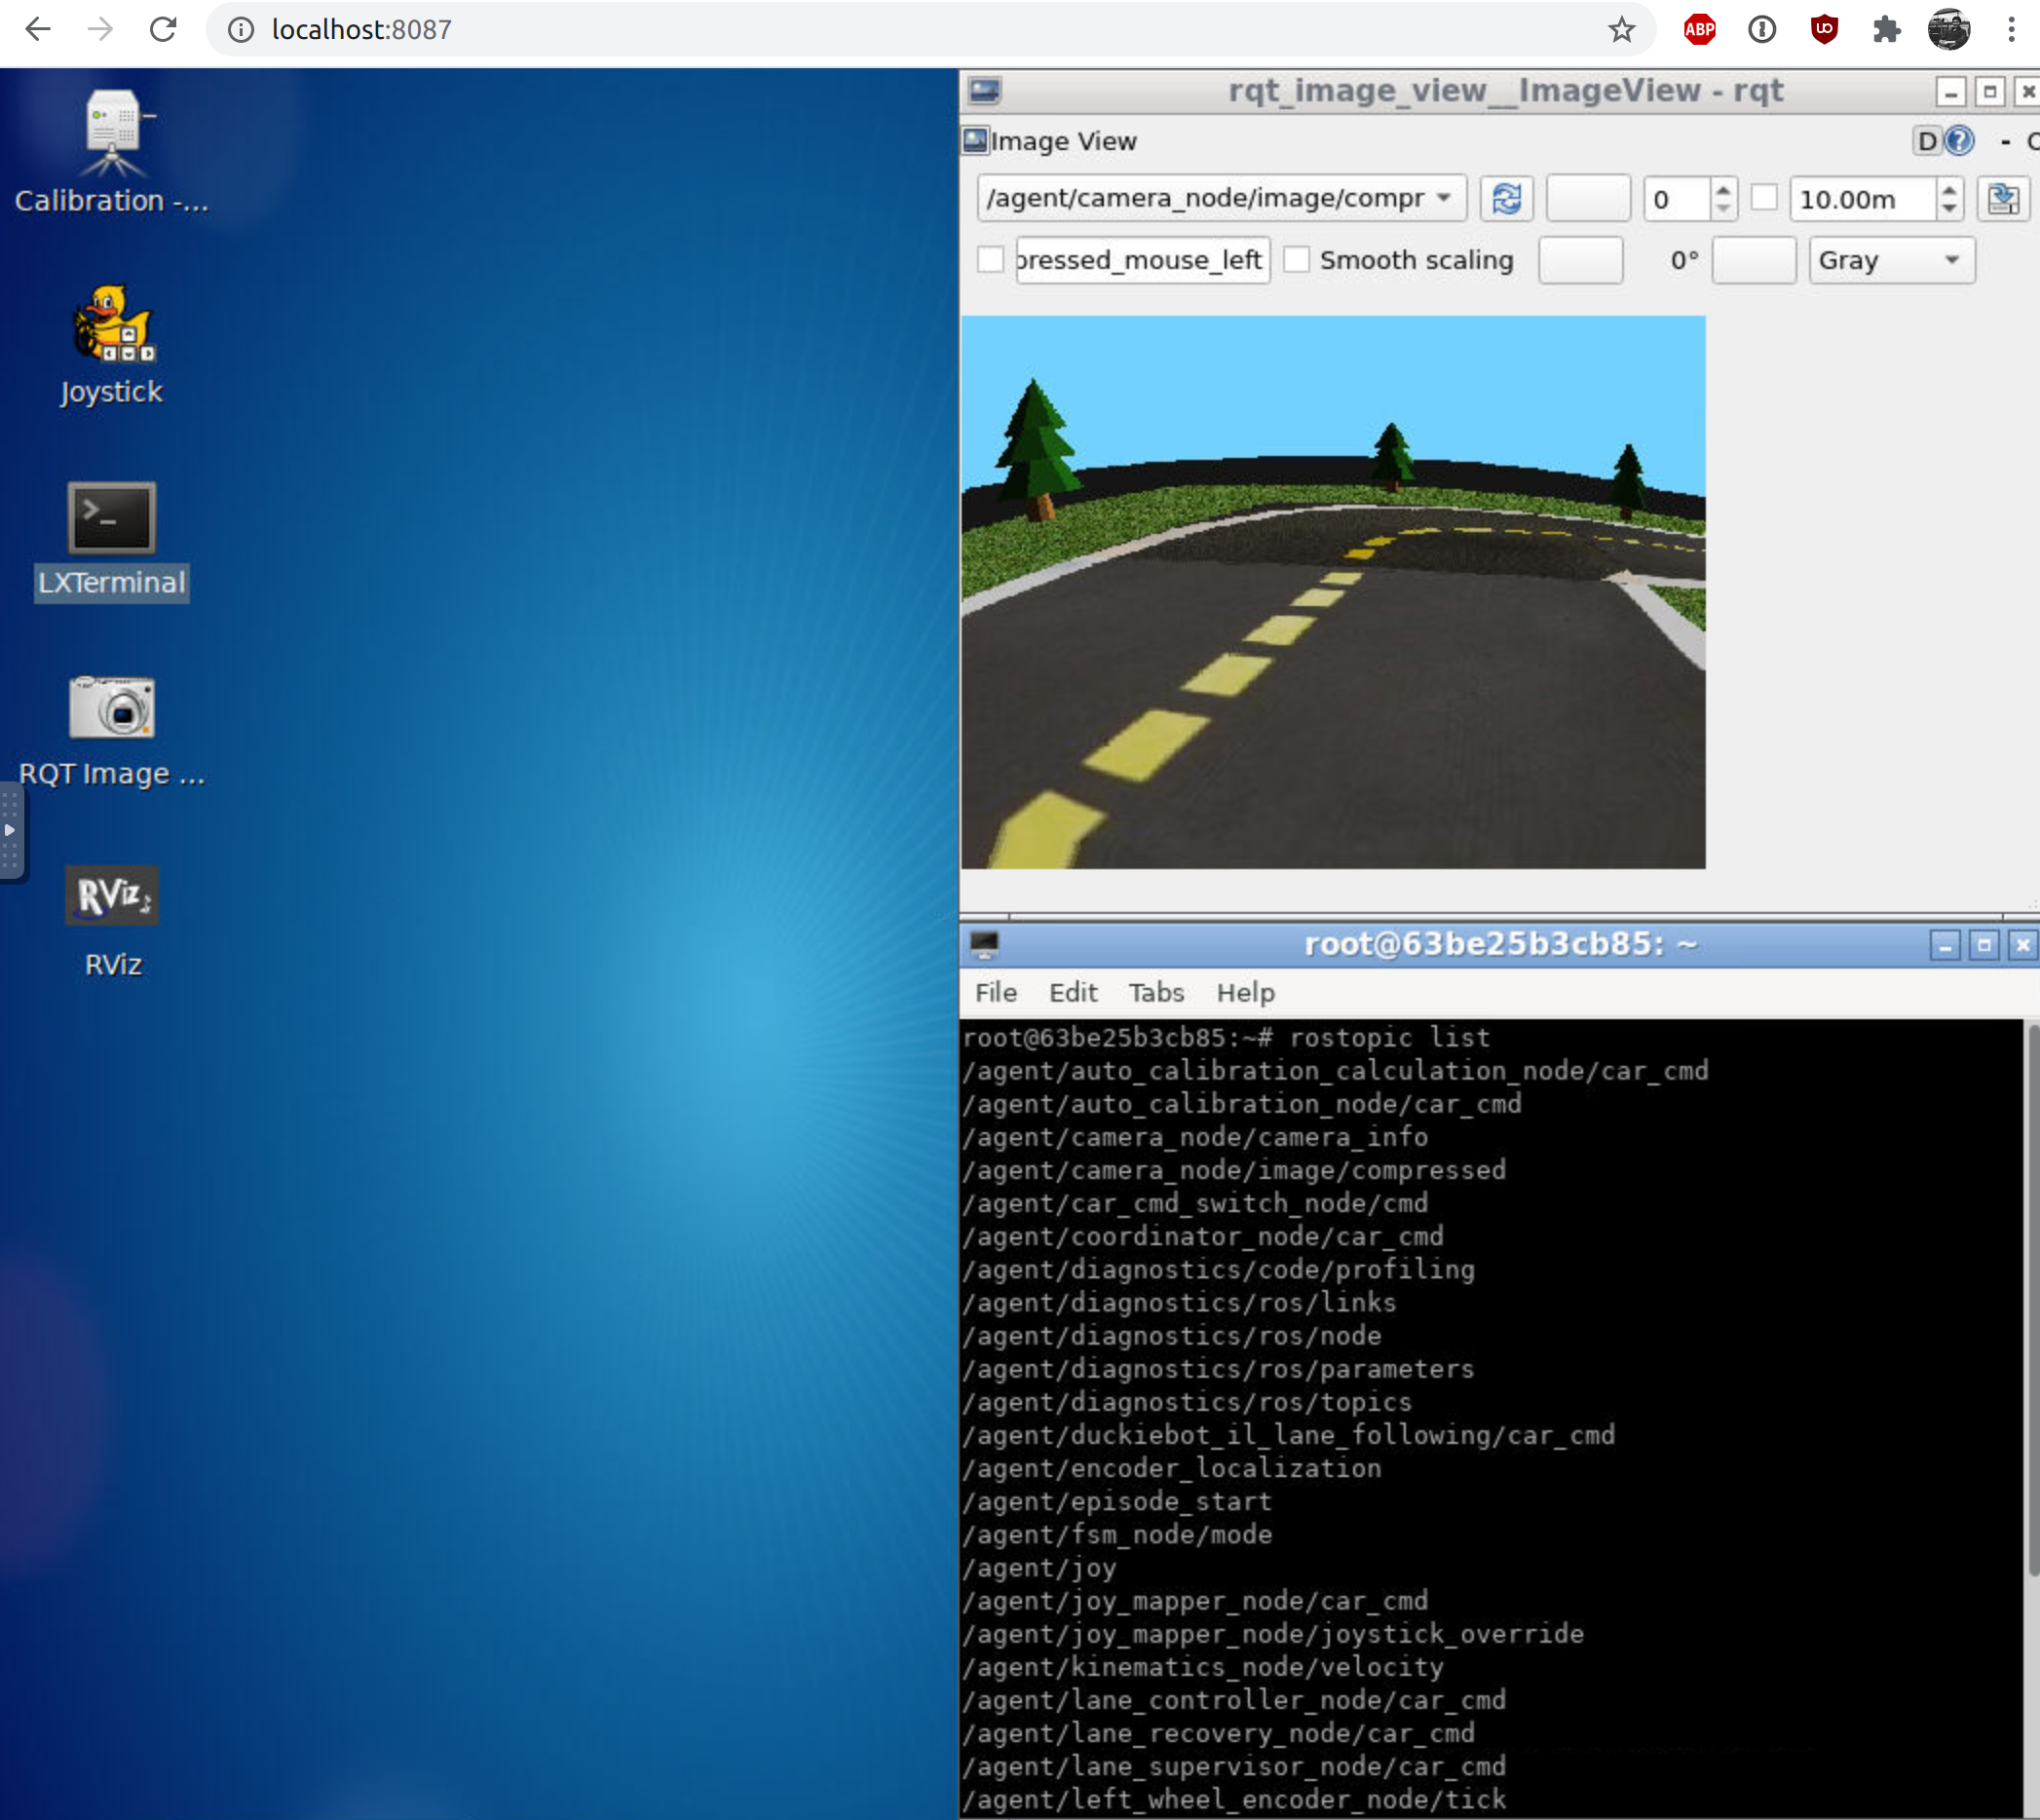</p> 

You can immagine a ROS topic as a "pipe" that is designed to allow messages of specific types to pass through. Messages carry the data we are interested about. 

3. To see the wheel encoder message of, for example, the left wheel, type: 

       rostopic echo /agent/left_wheel_encoder_node/tick

Now open the virtual joystick inside VNC (doube-click on the icon on the desktop) and start pressing your keyboard arrows to move. 

While you're driving, you can optionally see a birds-eye view by opening the other localhost address provided in the terminal from where you launched `dts exercises test --sim`, i.e., `http://localhost:8090/`. 

<p style="text-align:center;">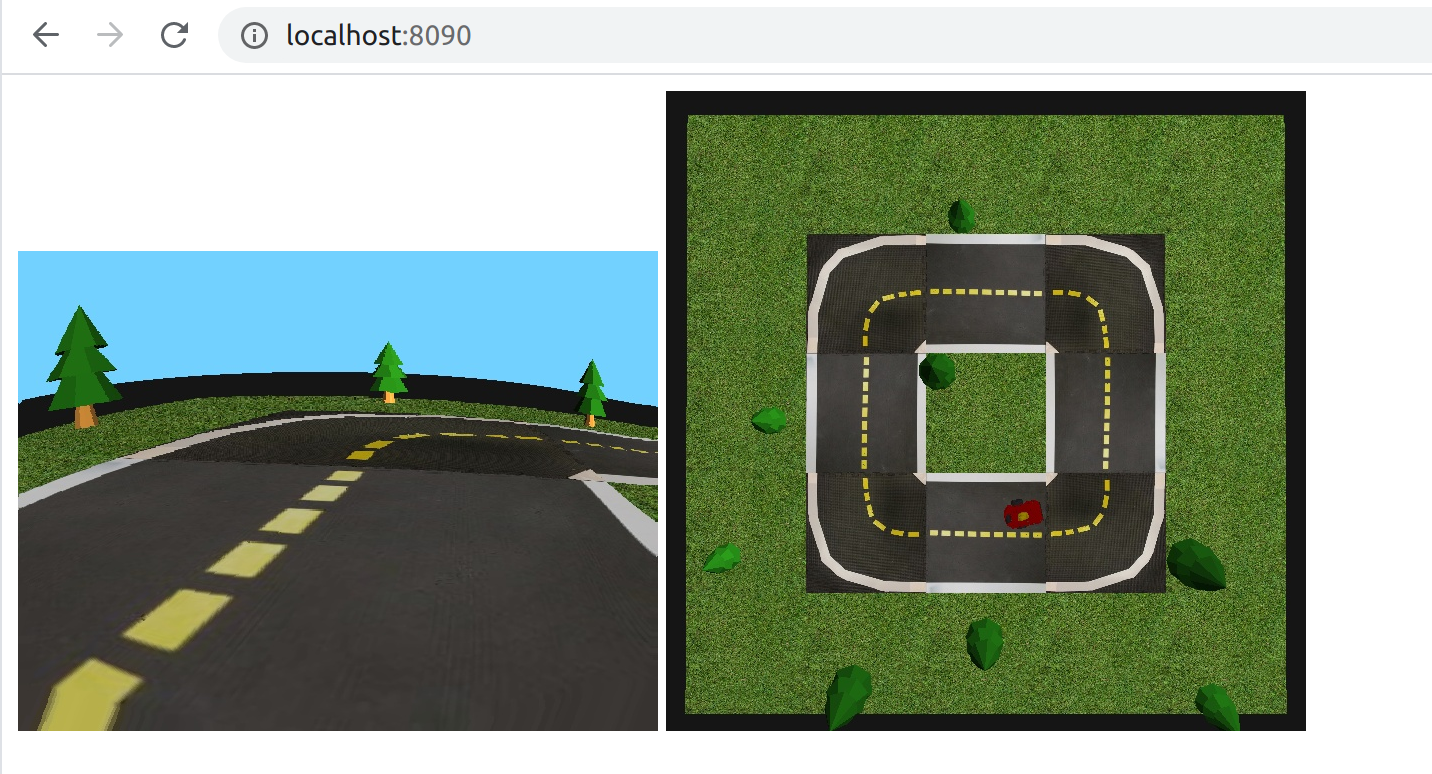</p> 

You will start seeing images moving (don't crash on a tree or you will have to restart!) and wheel encoder messages streaming on your terminal.

<p style="text-align:center;">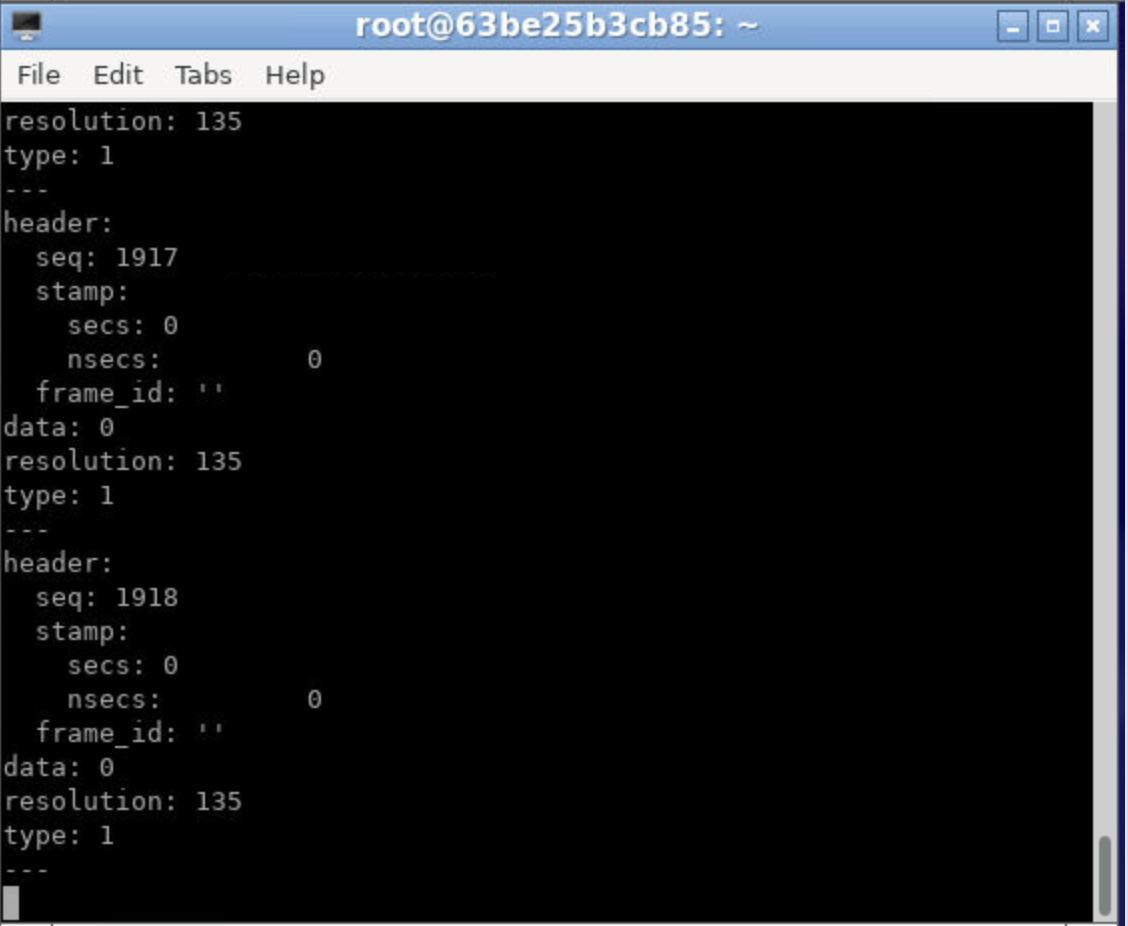</p>    

Messages will look like this:

```    
---
header: 
  seq: 372
  stamp: 
    secs: 1618436796
    nsecs:  55785179
  frame_id: "argo/left_wheel_axis"
data: 4
resolution: 135
type: 1
---
```    

Let's look at what each field means:

* `seq`: is an incremental identifier of the message. For each message received, it will increase by one. 
* `stamp`: the timestamp of the message.
* `data`: is the cumulative count of ticks from the encoder in this instance. It will increase if the wheel is spinning forward, decrease if backwards. This is the actual measurement we can use to build our algorithms going forward.
* `resolution`: is the total number of ticks for each full revolution of the wheel (a constant).
* `type`: indicates the kind of encoder measurements. `1` stands for [incremental measurements](https://github.com/duckietown/dt-ros-commons/blob/daffy/packages/duckietown_msgs/msg/WheelEncoderStamped.msg). 

### 🚙 Read data from wheel encoders (physical Duckiebot)

With a similar procedure, we can verify the wheel encoder data from the physical Duckiebot. 

Note: before starting this procedure, make sure your Duckiebot is powered on and connect to the network. You can verify this by opening the Dashboard > Robot page and assessing that everything is online, and / or `ping ROBOTNAME.local` from your computer terminal and obtain a positive response.

<p style="text-align:center;">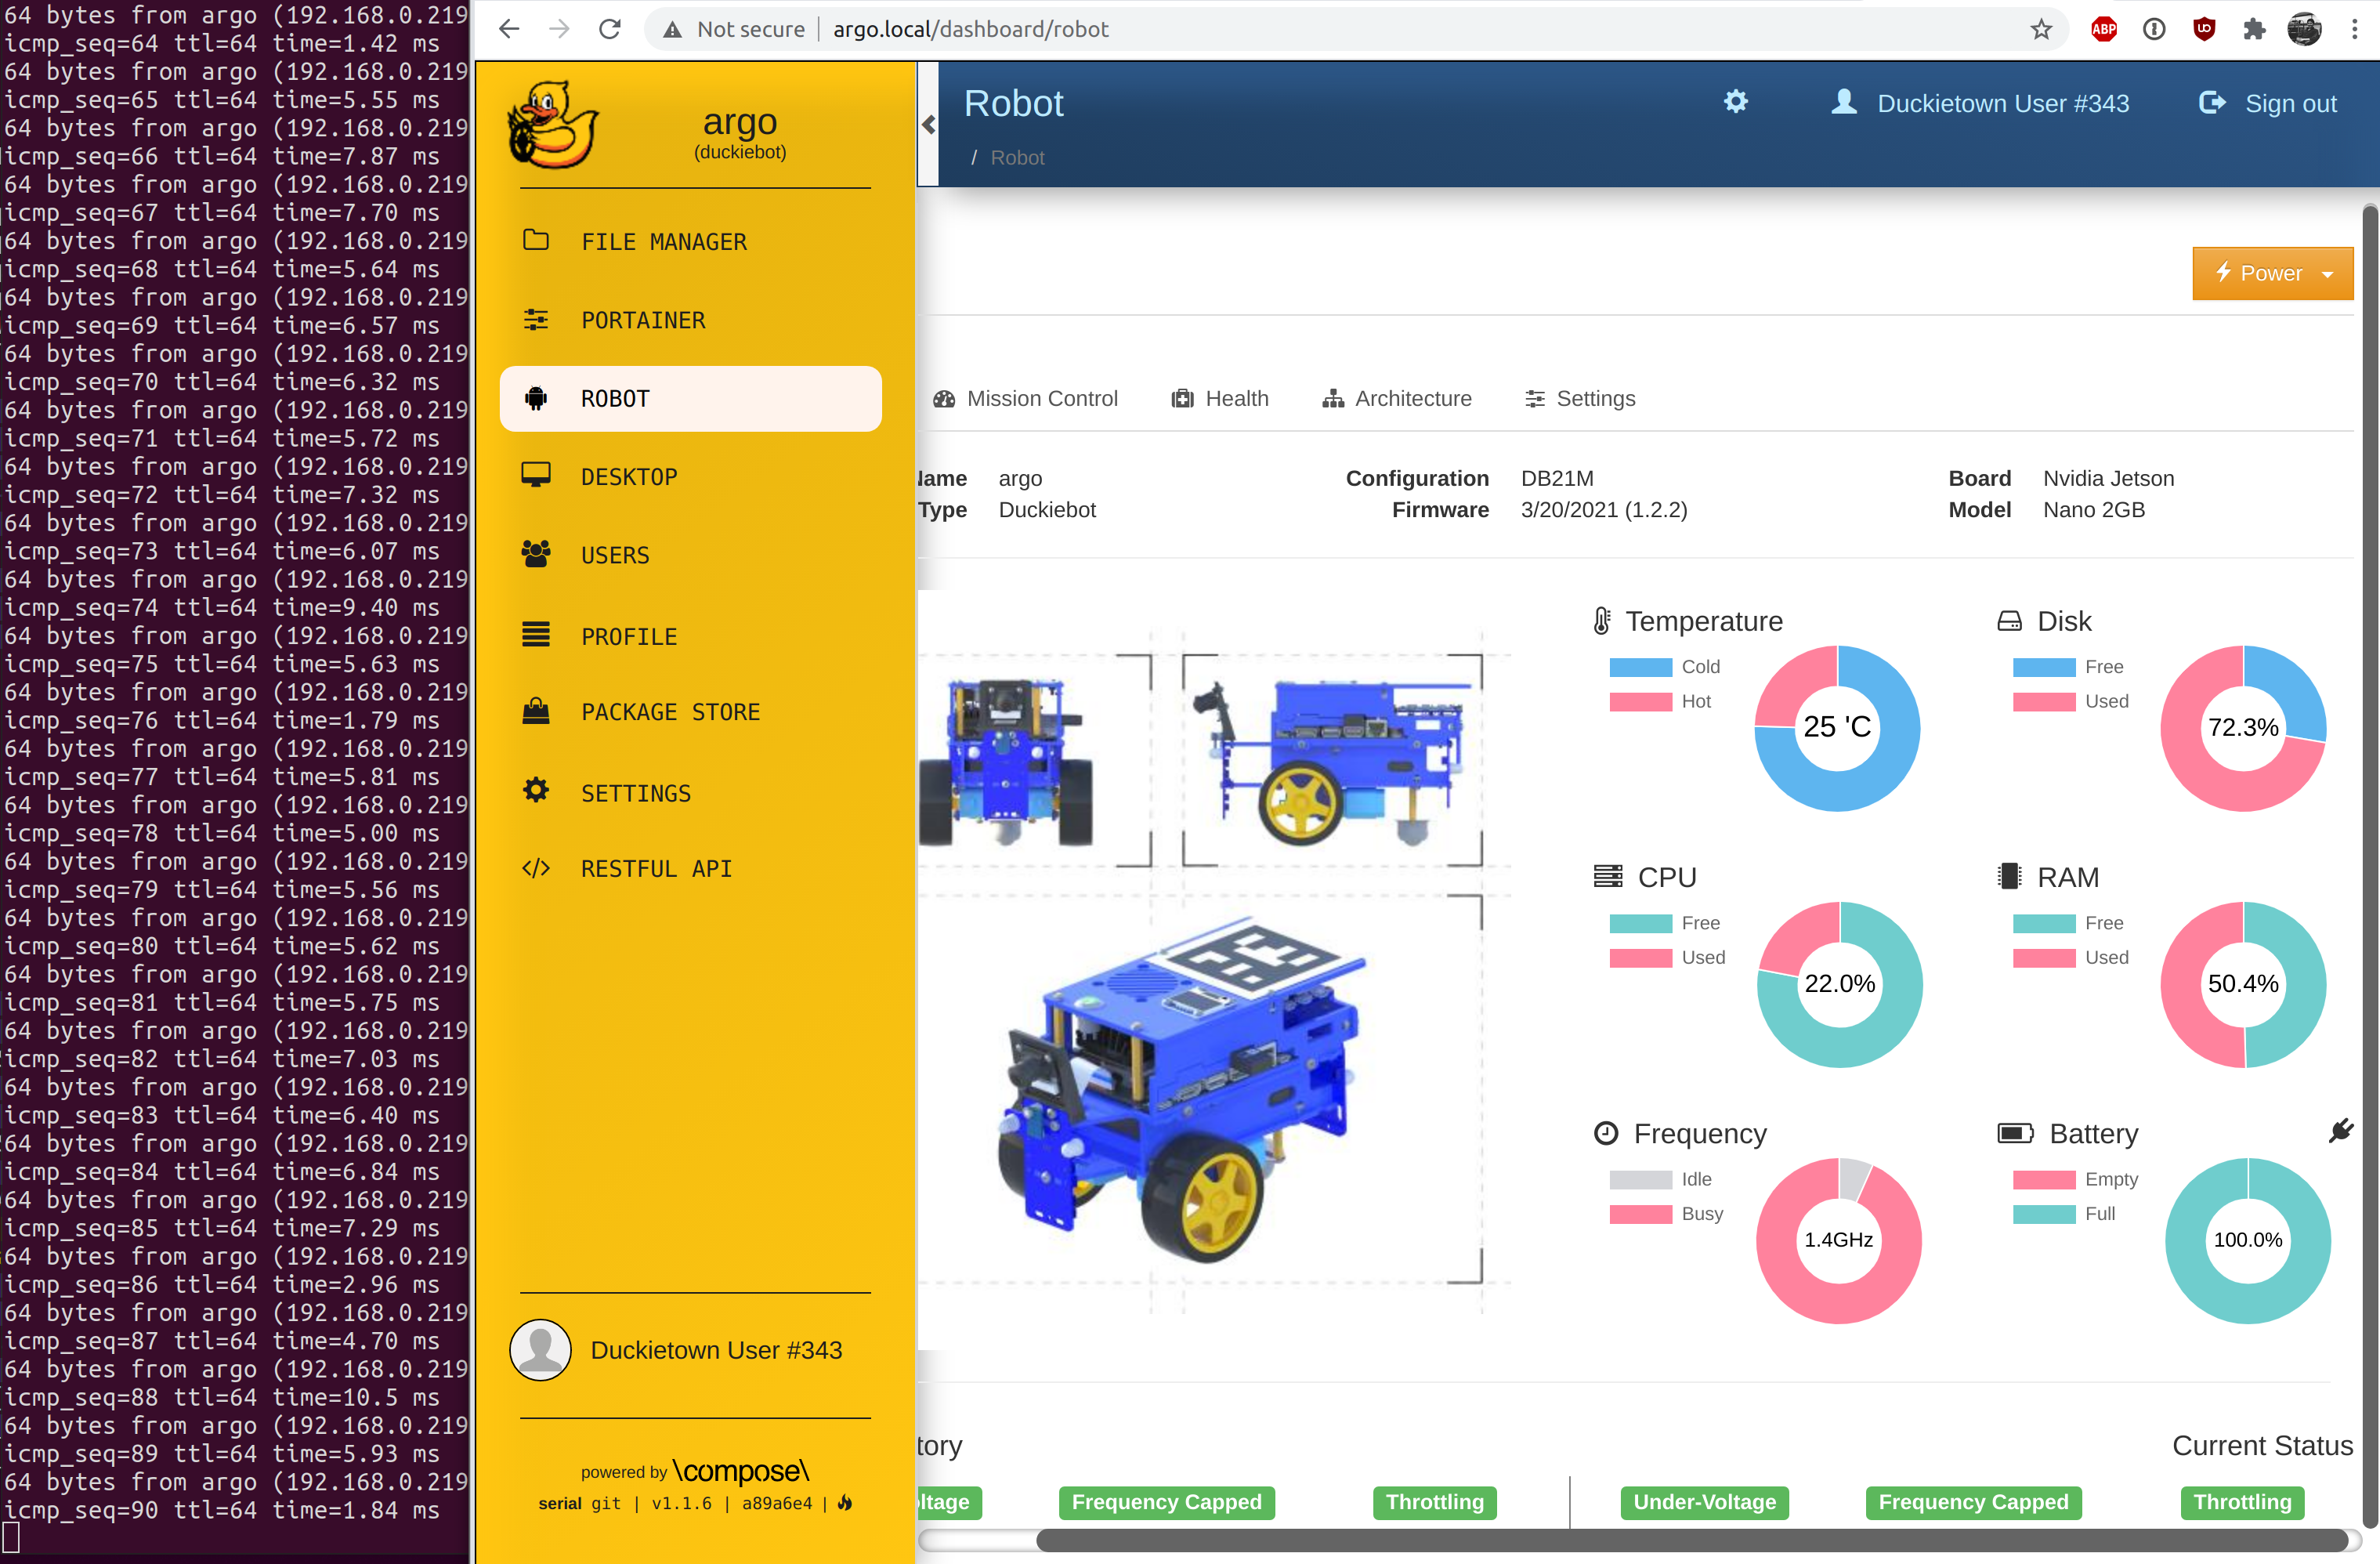</p> 

1. Open a terminal on your computer and navigate to the `mooc-exercises/mooc-modcon/` folder. Unless you did it already (but it won't break anything if you do it again), type: 

       dts exercises build

2. Run this activity on the 

       dts exercises test -b ROBOTNAME
     
3. Find the localhost address of VNC and paste it in browser. 
        
4. Once inside VNC, open RQT image view (through the icon on the desktop) and select the "compressed image" topic from the dropdown menu. You should see what your robot sees.
        
5. Open LX terminal (always inside VNC, through the icon on the desktop) and type:
    
       rostopic list
       
6. Find your wheel encoder topics, and visualize the messages with (e.g., for the left encoder):

       rostopic echo /ROBOTNAME/left_wheel_encoder_node/tick
       
7. Open the virtual joystick inside VNC and press any arrow key on your keyboard. You should see the robot moving and data streaming in the terminal. As in the simulation case, you will see the wheel encoder messages.

```    
---
header: 
  seq: 372
  stamp: 
    secs: 1618436796
    nsecs:  55785179
  frame_id: "argo/left_wheel_axis"
data: 4
resolution: 135
type: 1
---
```  

## Reading the number of ticks from each wheel

The wheel encoder message above provides several pieces of information. Let's extract the number of ticks. 


In [11]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

from unit_test import UnitTestMessage

# A ROS message in our case the encoder_msg is the argument passed by a ROS Subscriber to a callback function.

def EncoderCallback(encoder_msg):
    # encoder_msg is the msg from the encoders
    
    N_tot = encoder_msg.resolution # number of ticks per wheel revolution
    ticks = encoder_msg.data # incremental count of "ticks" from the encoder
    
    #Let's see if we've done it right
    print("The received message is :")
    print()
    print(encoder_msg)
    print()
    print(f"N. of ticks : {ticks}")
    print(f"Total ticks : {N_tot}")


# Testing the callback
UnitTestMessage(EncoderCallback)


The received message is :

header: 
  seq: 0
  stamp: 
    secs: 0
    nsecs:         0
  frame_id: "agent/left_wheel_axis"
data: 13
resolution: 135
type: 1

N. of ticks : 13
Total ticks : 135


You should now be able to read and understand wheel encoder data, and extract fields of interest from the messages. You can proceed to the next tutorial, the [odometry activity](../05-Odometry/odometry_activity.ipynb).